# Verifying the SpeechT5 model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Put this notebook at the same level as the `SpeechT5` repo.

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- To run on CPU: In `speecht5/sequence_generator.py`, comment out where it does `.to(device="cuda")`

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `speecht5_base_asr.pt` and `t5_transformer_lm.pt` from https://huggingface.co/ajyy/SpeechT5

You also need an input audio file, any WAV at 16 kHz will do.

In [1]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch

## Load audio and preprocess

In [4]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/141231/1272-141231-0020.flac"

In [5]:
import soundfile as sf
wav_data, cur_sample_rate = sf.read(input_file)
wav_data.shape, cur_sample_rate

((69120,), 16000)

NOTE: The `Wav2Vec2FeatureExtractor` does not make sure the audio file is mono. If it has shape `(2, length)` or even `(1, length)` then the output from the feature extractor is incorrect!

The `do_normalize` option is False for the SpeechT5 ASR model.

In [6]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(do_normalize=False, return_attention_mask=True)

In [7]:
inputs = feature_extractor(wav_data, sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs["input_values"].shape

torch.Size([1, 69120])

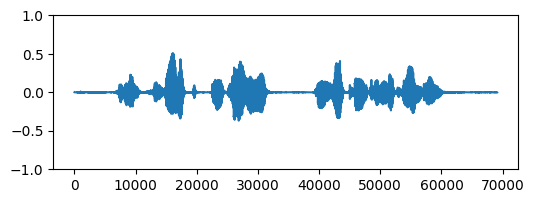

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 2))
plt.plot(inputs["input_values"][0])
plt.ylim(-1, 1)
plt.show()

Transform multiple inputs into a single padded batch:

In [9]:
input_file2 = "/Users/matthijs/Documents/FILES/HuggingFace/S2S/textless/AUDIO_DIR/selfdestruct.wav"
wav_data2, cur_sample_rate2 = sf.read(input_file2)
wav_data2.shape, cur_sample_rate2

((128632,), 16000)

In [10]:
inputs2 = feature_extractor([wav_data, wav_data2], sampling_rate=cur_sample_rate, padding=True)
inputs2["input_values"].shape

(2, 128632)

The original model used a `padding_mask` as input, where False means no padding. The `Wav2Vec2FeatureExtractor` can return an `attention_mask`, where 1 means no padding.

In [11]:
inputs2["attention_mask"]

[array([1, 1, 1, ..., 0, 0, 0], dtype=int32),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int32)]

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint. I used `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task s2t \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

NOTE: The conversion script is currently incomplete, so it prints a warning about "Unexpected key(s) in state_dict". This is normal at this point.

In [12]:
from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForCTC, 
    Wav2Vec2FeatureExtractor,
)

In [13]:
config = SpeechT5Config()
hf_model = SpeechT5Model(config)
#hf_model = SpeechT5ForCTC(config)

In [14]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr"
hf_model = SpeechT5Model.from_pretrained(model_checkpoint)

Some weights of SpeechT5Model were not initialized from the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr and are newly initialized: ['speecht5.speech_encoder_prenet.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note that loading should work OK for both the base class `SpeechT5Model` and `SpeechT5ForCTC`.

In [15]:
#hf_model = SpeechT5ForCTC.from_pretrained(model_checkpoint)

In [16]:
hf_model

SpeechT5Model(
  (speech_encoder_prenet): SpeechT5SpeechEncoderPrenet(
    (feature_encoder): SpeechT5FeatureEncoder(
      (conv_layers): ModuleList(
        (0): SpeechT5GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): SpeechT5NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): SpeechT5NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): SpeechT5NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): SpeechT5NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), 

Run a single forward pass. This should run the encoder, decoder, and the relevant pre- and postnets.

In [17]:
with torch.no_grad():
    hf_outputs = hf_model(**inputs)

type(hf_outputs)

transformers.modeling_outputs.Wav2Vec2BaseModelOutput

In [18]:
list(hf_outputs.keys())

['last_hidden_state', 'extract_features']

In [19]:
hf_outputs["extract_features"].shape

torch.Size([1, 215, 512])

In [20]:
hf_outputs["extract_features"]

tensor([[[-0.6318,  0.1265, -0.8733,  ...,  0.2677, -0.3374,  0.0058],
         [-1.3335, -0.7106, -0.6797,  ...,  0.0437,  0.1427,  0.5040],
         [-1.8898, -0.6588,  0.4209,  ...,  0.0444, -0.2682,  0.5834],
         ...,
         [-1.0058, -0.7280, -0.7392,  ...,  0.1703, -0.5074, -0.1430],
         [ 0.0079, -0.0941, -0.6969,  ..., -0.1035, -0.5059, -0.0286],
         [ 0.5507, -0.3121, -0.4363,  ..., -0.1503, -0.2760,  0.1200]]])

In [21]:
hf_outputs["last_hidden_state"].shape

torch.Size([1, 215, 768])

In [22]:
hf_outputs["last_hidden_state"]

tensor([[[ 7.3469, -3.7927, 10.4827,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.8800, -3.5574, 12.9277,  ...,  0.1729,  1.6734,  0.6476],
         [-1.9185,  3.3586, -0.4006,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 7.2030, -5.8764,  6.5531,  ...,  1.0349,  4.1734,  1.4926],
         [ 0.1941, -3.2425,  6.6313,  ..., -0.6757,  2.3840,  1.2404],
         [ 2.9908, -2.6358,  6.9353,  ...,  0.4324,  2.7151,  1.5720]]])

In [23]:
#hf_model.speech_encoder_prenet.embed_positions(padding_mask)

## Load the original model

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [24]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [25]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "s2t"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [26]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [28]:
checkpoint = torch.load("../weights/SpeechT5/speecht5_base_asr.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [29]:
#list(checkpoint["model"].keys())

## Verify speech encoder prenet output

This first uses the `speech_encoder_prenet` to convert the raw audio data into embeddings of shape `(batch, sequence_length, 768)`. The sequence length is roughly `number of audio samples / 320`, so there is one vector every 20 ms.

In [30]:
source = inputs["input_values"]
source.shape

torch.Size([1, 69120])

In [31]:
padding_mask = torch.BoolTensor(source.shape).fill_(False)

In [32]:
encoder_input, encoder_padding_mask = orig_model.speech_encoder_prenet(
    source, padding_mask=padding_mask, mask=False
)

In [33]:
# encoder_input = orig_model.speech_encoder_prenet.feature_extractor(source)
# encoder_input.shape

In [34]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([1, 215, 768]), torch.Size([1, 215]))

In [35]:
encoder_input

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 8.1539, -5.4359,  5.8689,  ...,  1.0349,  4.1734,  1.4926],
         [ 0.8112, -3.6817,  5.7369,  ..., -0.6757,  2.3840,  1.2404],
         [ 2.7066, -3.5683,  6.5834,  ...,  0.4324,  2.7151,  1.5720]]])

In [36]:
#encoder_padding_mask

If the weights and model were converted correctly, this should report zero or a very small number:

In [37]:
torch.max(torch.abs(encoder_input - hf_outputs["last_hidden_state"]))

tensor(0.9589)

In [38]:
# torch.abs(encoder_input - hf_outputs["last_hidden_state"])

## Verify Transformer encoder output

In [39]:
with torch.no_grad():
    encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [40]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([215, 1, 768])
encoder_padding_mask shape torch.Size([1, 215])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([215, 1, 81])


In [41]:
# TODO: compare to SpeechT5 model

## Verify text decoder prenet

First this calls `text_decoder_prenet`:

In [44]:
beam_size = 5
tokens = torch.tensor([2] * beam_size).reshape(beam_size, -1)
tokens.shape

torch.Size([5, 1])

In [45]:
incremental_state = {}  # no incremental state on first step

In [46]:
with torch.no_grad():
    prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state)

In [47]:
prev_output_tokens.shape

torch.Size([5, 1, 768])

In [48]:
tgt_mask

In [49]:
incremental_state

{}

In [50]:
# TODO: compare to SpeechT5 model

## Verify Transformer decoder output

In [51]:
# First, reorganize the dictionary into a dictionary of lists
bsz = 1
new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
encoder_outs = orig_model.encoder.reorder_encoder_out(encoder_output, new_order)

In [52]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_outs,
        incremental_state=incremental_state,
    )

In [53]:
decoder_output.shape

torch.Size([5, 1, 768])

In [54]:
[x.shape for x in extra["attn"]]

[torch.Size([5, 1, 215])]

In [55]:
[x.shape for x in extra["inner_states"]]

[torch.Size([1, 5, 768]),
 torch.Size([1, 5, 768]),
 torch.Size([1, 5, 768]),
 torch.Size([1, 5, 768]),
 torch.Size([1, 5, 768]),
 torch.Size([1, 5, 768]),
 torch.Size([1, 5, 768])]

In [56]:
# TODO verify

In [57]:
# np.max(np.abs(extra["attn"][0].numpy() - expected))

In [58]:
#predicted = [x.numpy() for x in extra["inner_states"]]
# for i in range(len(expected)):
#     print(np.max(np.abs(predicted[i] - expected[i])))

## Verify text decoder postnet output

In [59]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [60]:
lprobs.shape

torch.Size([5, 1, 81])

In [61]:
# TODO: verify

## Use the `transformers` generator loop: